# Watt-Seer Household- Smart Energy Insights for Smarter Homes

In [19]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/smart-home-energy-consumption/smart_home_energy_consumption_large.csv


In [20]:
# some useful libraries to import
# Import NumPy library for numerical operations and linear algebra
import numpy as np # linear algebra
# Import Pandas library for data manipulation and analysis
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
# Import matplotlib's pyplot for plotting and visualization
import matplotlib.pyplot as plt
# Import Seaborn for statistical data visualization
import seaborn as sns
# Apply Seaborn's default theme for all plots
sns.set_theme() # apply the default theme
# Import normaltest from scipy.stats for normality testing
from scipy.stats import normaltest
# Import kruskal from scipy.stats for Kruskal-Wallis H-test
from scipy.stats import kruskal
# Import warnings module to handle warnings
import warnings
# Ignore all warnings to keep output clean
warnings.filterwarnings('ignore')
# Import RandomForestRegressor from sklearn for random forest regression
from sklearn.ensemble import RandomForestRegressor
# Import LabelEncoder from sklearn for categorical variable encoding
from sklearn.preprocessing import LabelEncoder
# Import train_test_split from sklearn for splitting data into train/test sets
from sklearn.model_selection import train_test_split
# Import PCA from sklearn for principal component analysis
from sklearn.decomposition import PCA
# Import mean_squared_error from sklearn for regression performance metric
from sklearn.metrics import mean_squared_error

# Data Loading and Initial Exploration

In [21]:
# data path
data_path = "/kaggle/input/smart-home-energy-consumption/smart_home_energy_consumption_large.csv"

# Load the data
df = pd.read_csv(data_path)

# Display sample, total are 10K rows
df.head()

,Home ID,Appliance Type,Energy Consumption (kWh),Time,Date,Outdoor Temperature (°C),Season,Household Size
0,94,Fridge,0.20,21:12,2023-12-02,-1.0,Fall,2
1,435,Oven,0.23,20:11,2023-08-06,31.1,Summer,5
2,466,Dishwasher,0.32,06:39,2023-11-21,21.3,Fall,3
3,496,Heater,3.92,21:56,2023-01-21,-4.2,Winter,1
4,137,Microwave,0.44,04:31,2023-08-26,34.5,Summer,5


**Dataset Overview:**

- 100,000 rows × 8 columns

- 500 unique households

- Data collected from Jan-Dec 2023

- Appliances tracked: Air Conditioning, Computer, Dishwasher, Fridge, Heater, Lights, Microwave, Oven, TV, Washing Machine

In [22]:
# Dimensions of the dataframe
df.shape

(100000, 8)

In [23]:
# features name in the dataset
print(df.columns.tolist())  # prints full names as a list

['Home ID', 'Appliance Type', 'Energy Consumption (kWh)', 'Time', 'Date', 'Outdoor Temperature (°C)', 'Season', 'Household Size']


In [24]:
# there is no NA in the dataset
df.isna().agg(lambda x: sum(x)) # to count NA by feature

Home ID                     0
Appliance Type              0
Energy Consumption (kWh)    0
Time                        0
Date                        0
Outdoor Temperature (°C)    0
Season                      0
Household Size              0
dtype: int64

In [25]:
home_id = np.unique(df['Home ID']) # retrieve homes id
print('The number of households in the dataset: ',len(home_id))

The number of households in the dataset:  500


In [26]:
# data from the first household
df[df['Home ID'] == home_id[0]].head()

,Home ID,Appliance Type,Energy Consumption (kWh),Time,Date,Outdoor Temperature (°C),Season,Household Size
276,1,Washing Machine,1.65,05:09,2023-09-06,30.7,Summer,4
1022,1,Oven,1.66,01:05,2023-09-06,-7.1,Summer,2
1273,1,Fridge,0.47,11:09,2023-08-04,9.5,Summer,2
1463,1,Microwave,1.63,12:27,2023-03-17,14.8,Winter,2
2122,1,Computer,1.61,23:26,2023-10-24,37.5,Fall,1


In [27]:
# in household '1', data have been collected from 2023-01-05 to 2023-12-31
print('In household 1, data have been collected from ',np.unique(df[df['Home ID'] == home_id[0]]['Date'])[[0,-1]].tolist())

In household 1, data have been collected from  ['2023-01-05', '2023-12-31']


In [28]:
# in household '3', data have been collected from 2023-01-02 to 2023-12-31
print('In household 3, data have been collected from ',np.unique(df[df['Home ID'] == home_id[2]]['Date'])[[0,-1]].tolist())

In household 3, data have been collected from  ['2023-01-02', '2023-12-31']


Data collection days may change by household.

In [29]:
# create the 'Datetime' concatenating 'Date' and 'Time'
df['Datetime'] = pd.to_datetime(df['Date'] + ' ' + df['Time'], errors='coerce')

# the number of day time data have been collected in the household '1'
print('Number of day time data have been collected in the household 1:',len(np.unique(df[df['Home ID'] == home_id[0]]['Datetime'])))

# the number of day time data have been collected in the household '2'
print('Number of day time data have been collected in the household 2:',len(np.unique(df[df['Home ID'] == home_id[2]]['Datetime'])))

Number of day time data have been collected in the household 1: 211
Number of day time data have been collected in the household 2: 216


The number of date time of data collection may also vary by household.

In [30]:
# a function to retreive the number of day time data have been collected in a household
def numb_day_collect(x): return len(np.unique(df[df['Home ID'] == x]['Datetime']))

# number of day time for data collection in each household
numb_day_collect_inhouse = [numb_day_collect(x) for x in home_id]

print('Min and Max number of day time for household data collection:', np.percentile(numb_day_collect_inhouse, [0, 100]))

print('Mean and Standard error of day time are:', np.mean(numb_day_collect_inhouse), 'and', np.std(numb_day_collect_inhouse).round(2))

Min and Max number of day time for household data collection: [157. 245.]
Mean and Standard error of day time are: 199.95 and 13.86


Households don't have the same number of date time of data collection. The variability within the number of date time in the households is quite important.

In [31]:
# the appliances described in the dataset
np.unique(df['Appliance Type']).tolist()

['Air Conditioning',
 'Computer',
 'Dishwasher',
 'Fridge',
 'Heater',
 'Lights',
 'Microwave',
 'Oven',
 'TV',
 'Washing Machine']

# Data description
The dataset describes $500$ **households** based on seven features that are: 1) the **household size**, i.e. the number of people living in the household, 2) the **appliances** they use, 3) the **energy consumed** by these appliances in 4) **which season**, with 5) what **outdoor temperature**, 6) which **day** and 7) which **time**.

Data collection days and times may change by household, with a quite significant variability within the number of date time data have been collected in the households. These numbers range from $157$ to $245$ with a mean value of $200$ and a standard deviation of $13.86$. The data was collected in 2023, from January to December for all the households. The appliances used in the households are: **Air Conditioning**, **Computer**, **Dishwasher**, **Fridge**, **Heater**, **Lights**, **Microwave**, **Oven**, **TV**, and **Washing Machine**.    

# Preliminary analysis of the dataset

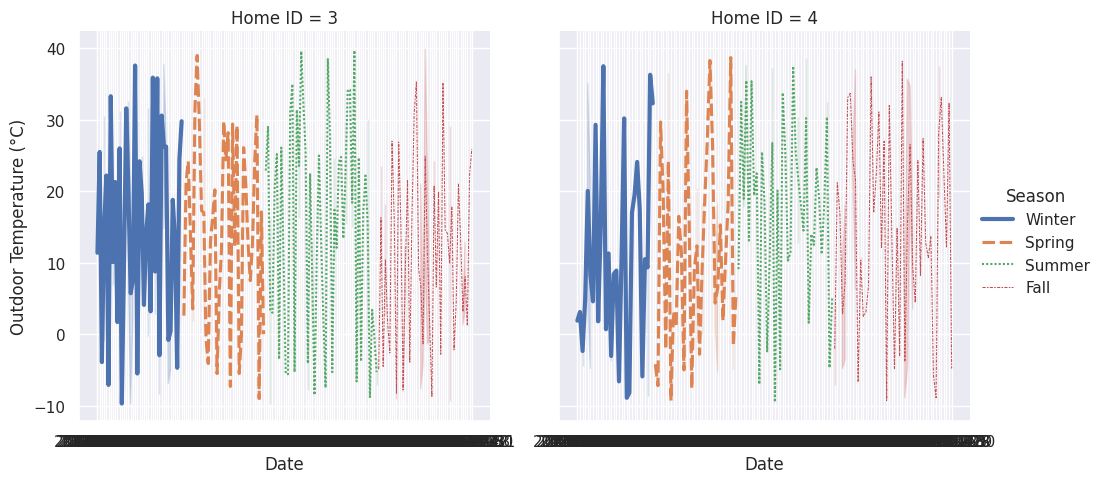

In [32]:
# Select data from the 3rd and 4th households
# Sort the dataframe by date to ensure chronological order
df = df.sort_values('Date') # sorting values by 'Date'
# Filter dataframe to only include rows where Home ID matches either the 3rd or 4th home in home_id list
df_home3_4 = df[(df['Home ID'] == home_id[2]) | (df['Home ID'] == home_id[3])] 

# Create a reference to the filtered data for plotting
data = df_home3_4 # the data we want to plot

# Create a relational plot showing temperature patterns by season
# Using seaborn's relplot to create a multi-panel figure
sns.relplot(
    # Specify the data source
    data = data,
    # Set x-axis to Date
    x = 'Date', 
    # Set y-axis to Outdoor Temperature
    y = 'Outdoor Temperature (°C)',
    # Create separate columns for each Home ID
    col = 'Home ID',
    # Color lines by Season
    hue = 'Season',
    # Different line styles for each Season
    style = 'Season',
    # Use line plot type
    kind = 'line',
    # Vary line thickness by Season
    size = 'Season',
    # Allow each subplot to have independent x-axis scaling
    facet_kws = dict(sharex = False)
)

The Figure above plots the evolution of the outdoor temperature for the households ``3``and ``4`` by season. It seems to appear that there is no clear effect of the season on the outdoor temperature for these two households. To clarify this for all the households, we could fit, at least, a linear model (for example, a One-way ANOVA) to the data. But first of all, we need to check if the data are drown from a Gaussian distribution.

# Statistical Analysis

# Normality Test
1. Objective

    - Determines whether a dataset follows a Gaussian/normal distribution

2. Test Methodology

    - Uses D'Agostino-Pearson test (combines skewness and kurtosis measures)
        
    - Calculates a test statistic (K²) that quantifies deviations from normality

3. Hypotheses

    - Null (H₀): Data is normally distributed
    
    - Alternative (H₁): Data is not normally distributed

4. Interpretation

    - p-value < α (typically 0.05) → Reject H₀ (non-normal)
    
    - p-value ≥ α → Fail to reject H₀ (normal)

5. Key Assumptions

    - Independent observations
    
    - No extreme outliers
    
    - Adequate sample size (n > 20 recommended)

6. Applications

    - Validates assumptions for parametric tests (t-tests, ANOVA, etc.)
    
    - Guides choice between parametric/non-parametric methods

7. Limitations

    - Sensitive to large sample sizes (may detect trivial deviations)
    
    - Should be complemented with visual checks (Q-Q plots, histograms)

In [33]:
# Perform D'Agostino-Pearson normality test on outdoor temperature data
# The test returns two values - we ignore the first (_) and keep the p-value (p)
_, p = normaltest(df['Outdoor Temperature (°C)'])
# interpret results
# Set significance level (alpha) for hypothesis testing
alpha = 0.05
# Check if p-value is greater than our significance level
if p > alpha:
    # If p > alpha, we fail to reject the null hypothesis of normality
    print("Outdoor temperatures look Gaussian.")
else:
    # If p <= alpha, we reject the null hypothesis of normality
    print("Outdoor temperatures don't look Gaussian.")

Outdoor temperatures don't look Gaussian.



Since the outdoor temperatures are not Gaussian, we have to perform a non parametric test to clarify the season effect on the outdoor temperatures.

# Seasonal Analysis (Kruskal-Wallis Test)

*Purpose:* Determines if energy consumption differs significantly across seasons.

*Key Steps:*
- Data Preparation

    - Splits temperature data by season (Winter, Spring, Summer, Fall)
    
    - Uses non-parametric test (no normality assumption required)

- Hypothesis Testing

    - Null Hypothesis: All seasons have identical temperature distributions
    
    - Test Statistic: H-value (ranks-based comparison)

- Result Interpretation

In [34]:
# Extract season data for analysis
# Create numpy array of winter temperatures by filtering dataframe for Winter season
Winter = np.array(df[df['Season'] == 'Winter']['Outdoor Temperature (°C)'])
# Create numpy array of spring temperatures by filtering dataframe for Spring season
Spring = np.array(df[df['Season'] == 'Spring']['Outdoor Temperature (°C)'])
# Create numpy array of summer temperatures by filtering dataframe for Summer season
Summer = np.array(df[df['Season'] == 'Summer']['Outdoor Temperature (°C)'])
# Create numpy array of fall temperatures by filtering dataframe for Fall season
Fall = np.array(df[df['Season'] == 'Fall']['Outdoor Temperature (°C)'])

# Perform Kruskal-Wallis H-test (non-parametric ANOVA alternative)
# Tests whether samples come from identical distributions
# We ignore the H-statistic (_) and keep only the p-value (p)
_, p = kruskal(Winter, Spring, Summer, Fall)

# interpret results
# Set significance threshold (probability of Type I error)
alpha = 0.05
# Compare p-value to significance level
if p > alpha:
    # Fail to reject null hypothesis - distributions are not significantly different
    print("Outdoor temperatures have the same distribution per season.")
else:
    # Reject null hypothesis - at least one season differs significantly
    print("Outdoor temperatures don't have the same distribution per season.")

Outdoor temperatures have the same distribution per season.


Curiously, the outdoor temperatures are significantly of the same distribution for all the seasons (Winter, Spring, Summer, and Fall). Then, based on the previous analysis, **the seasons don't explain the variability contained in the outdoor temperatures**.

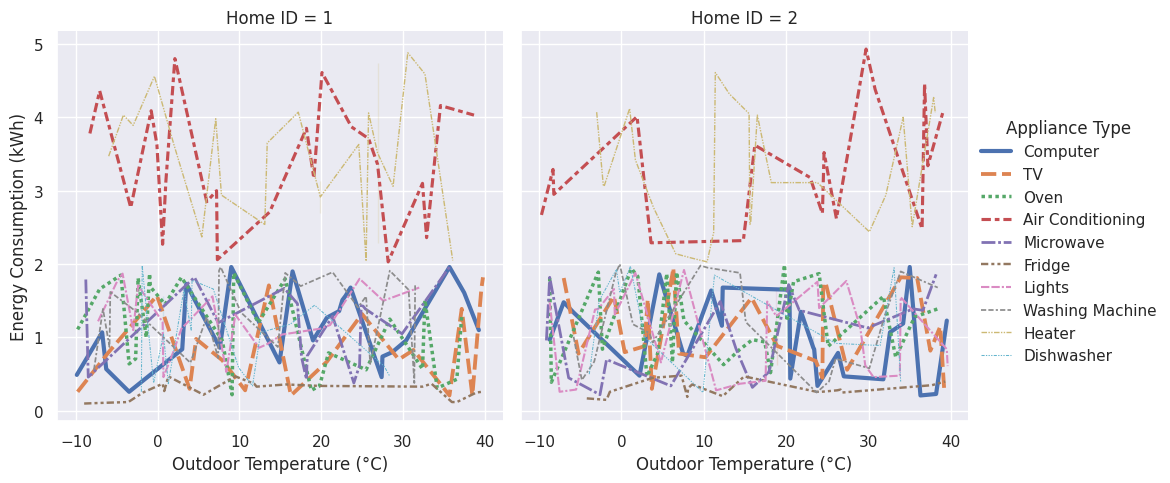

In [35]:
# Focus on data from the first two households in our dataset
# Sort the dataframe by outdoor temperature (ascending order)
df = df.sort_values('Outdoor Temperature (°C)') # sorting values by 'Temperature'
# Filter to only include homes with ID matching either first or second in home_id list
df_home1_2 = df[(df['Home ID'] == home_id[0]) | (df['Home ID'] == home_id[1])]

# Create reference to filtered data for cleaner plotting code
data = df_home1_2 # the data we want to plot

# Create a relational plot to visualize energy consumption patterns
# This will show how different appliances respond to temperature changes
sns.relplot(
    # Data source for the visualization
    data = data,
    # X-axis represents outdoor temperature values
    x = 'Outdoor Temperature (°C)', 
    # Y-axis shows corresponding energy consumption values
    y = 'Energy Consumption (kWh)',
    # Create separate subplots for each home (side-by-side comparison)
    col = 'Home ID',
    # Color coding based on appliance category
    hue = 'Appliance Type',
    # Different line styles for each appliance type
    style = 'Appliance Type',
    # Use line plot to show trends
    kind = 'line',
    # Vary line thickness by appliance type
    size = 'Appliance Type',
    # Allow x-axis scales to vary independently between subplots
    facet_kws = dict(sharex = False)
)

Air conditioning and heaters seem to be the two most consumptive appliances in households, regardless of the outdoor temperatures.

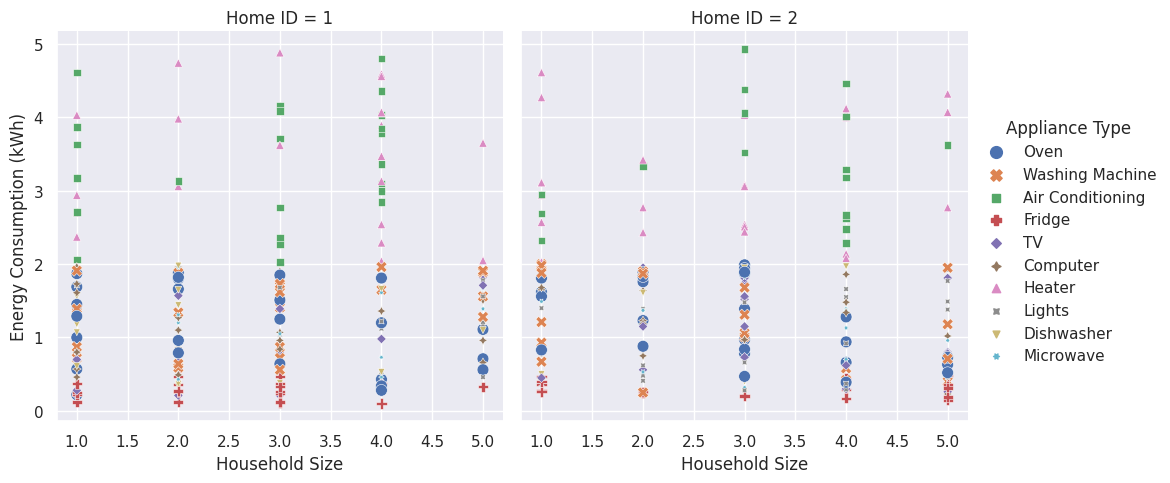

In [36]:
# Analyzing data from the first two households in the dataset
# Sort the dataframe by household size (number of occupants)
df = df.sort_values('Household Size') # sorting values by 'Household Size'
# Filter to include only the first two homes from our home_id list
df_home1_2 = df[(df['Home ID'] == home_id[0]) | (df['Home ID'] == home_id[1])]

# Create a reference to the filtered data for plotting
data = df_home1_2 # the data we want to plot

# Create a relational plot to examine energy consumption patterns
# This visualization explores how household size affects energy usage
sns.relplot(
    # Specify the DataFrame containing our data
    data = data,
    # X-axis represents the number of people in the household
    x = 'Household Size', 
    # Y-axis shows the corresponding energy consumption
    y = 'Energy Consumption (kWh)',
    # Create separate subplots for each home to enable comparison
    col = 'Home ID',
    # Color differentiation by appliance category
    hue = 'Appliance Type',
    # Distinct line styles for each appliance type
    style = 'Appliance Type',
    # Vary line thickness by appliance type for additional visual distinction
    size = 'Appliance Type',
    # Allow x-axis scales to be independent between subplots
    facet_kws = dict(sharex = False)
)

Air conditioning and heaters seem to remain the most consumptive appliances in the household regardless of the household's size.

Now, let's see the behavior of the mean energy consumption of the appliances, regardless of the household.

In [37]:
# Compute aggregated mean statistics for energy analysis
# First sort by datetime to ensure chronological order before grouping
df_mean = df.sort_values('Datetime').groupby(['Home ID','Season','Appliance Type'])[['Energy Consumption (kWh)','Outdoor Temperature (°C)','Household Size']].agg(lambda x: np.mean(x))

# Rename columns to clearly indicate they contain mean values
df_mean = df_mean.rename(columns={
    'Energy Consumption (kWh)':'Mean Energy Consumption (kWh)',
    'Outdoor Temperature (°C)':'Mean Outdoor Temperature (°C)',
    'Household Size':'Mean Household Size'})

# Display the first few rows of the resulting dataframe
df_mean.head()

Mean Energy Consumption (kWh)  \
Home ID Season Appliance Type                                    
1       Fall   Air Conditioning                       3.210000   
               Computer                               0.982857   
               Dishwasher                             1.046667   
               Fridge                                 0.254286   
               Lights                                 1.250000   

                                 Mean Outdoor Temperature (°C)  \
Home ID Season Appliance Type                                    
1       Fall   Air Conditioning                      19.220000   
               Computer                              22.100000   
               Dishwasher                             2.400000   
               Fridge                                17.728571   
               Lights                                 4.850000   

                                 Mean Household Size  
Home ID Season Appliance Type                         
1       Fall   Air Conditioning             2.600000  
               Computer                     2.285714  
               Dishwasher                   2.000000  
               Fridge                       2.285714  
               Lights                       3.833333

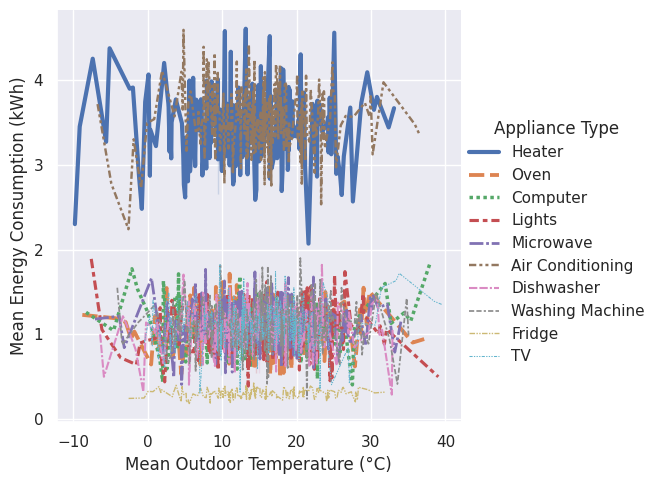

In [38]:
# Prepare data for visualization from all households
# Sort the aggregated mean values by temperature to show trends clearly
df_mean = df_mean.sort_values('Mean Outdoor Temperature (°C)') # sorting values by 'Temperature'

# Sample every 10th row to reduce data density for cleaner visualization
# while preserving overall trends (downsampling for better plot readability)
data = df_mean[::10] # the data we want to plot

# Create a relational plot to visualize the temperature-energy relationship
sns.relplot(
    # Use the downsampled mean values dataset
    data = data,
    # X-axis: Mean outdoor temperature (sorted in ascending order)
    x = 'Mean Outdoor Temperature (°C)', 
    # Y-axis: Corresponding mean energy consumption values
    y = 'Mean Energy Consumption (kWh)',
    # Color differentiation by appliance category
    hue = 'Appliance Type',
    # Distinct line styles for each appliance type
    style = 'Appliance Type',
    # Line plot type to show trends across temperature ranges
    kind = 'line',
    # Vary line thickness by appliance type for additional visual distinction
    size = 'Appliance Type',
    # Allow flexible x-axis scaling if needed
    facet_kws = dict(sharex = False)
)

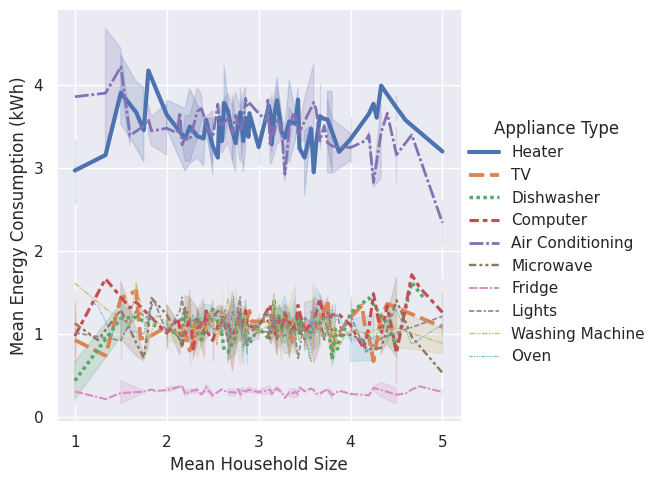

In [40]:
# Prepare aggregated data from all households for visualization
# Sort the dataframe by mean household size to show progression from small to large households
df_mean = df_mean.sort_values('Mean Household Size') # sorting values by 'Household Size'

# Create a downsampled version of the data (taking every 10th row) for cleaner visualization
# This reduces overplotting while preserving the overall trends
data = df_mean[::10] # the data we want to plot

# Create a multi-faceted relational plot to analyze energy consumption patterns
sns.relplot(
    # Specify the downsampled dataset containing mean values
    data = data,
    # Set x-axis to represent household size (number of occupants)
    x = 'Mean Household Size', 
    # Set y-axis to show corresponding energy consumption values
    y = 'Mean Energy Consumption (kWh)',
    # Color-code lines by appliance type for quick visual identification
    hue = 'Appliance Type',
    # Use different line styles (solid, dashed, etc.) per appliance type
    style = 'Appliance Type',
    # Choose line plot to best show trends across household sizes
    kind = 'line',
    # Vary line thickness by appliance type for additional visual distinction
    size = 'Appliance Type',
    # Allow flexible x-axis scaling between different facets if needed
    facet_kws = dict(sharex = False)
)

The last two Figures plot the curve of the mean energy consumption of appliances conditional on the mean outdoor temperature and the mean household size respectively. These Figures confirm that Air conditioning and heaters are the most consumptive appliances. It also appears in these Figures that fridges are the lowest consuming appliances.

# Preliminary analysis results
The preliminary analysis of the data shows that:
- The seasons do not affect the variation of the outdoor temperature.
- The most consumptive energy appliances are air conditioning and heaters.
- The least consumptive energy appliances are fridges.

In the next section, by using a Generative AI, we will confirm the preliminary analysis results. We also will address the following questions, along with out-of-the-scope queries:
- **By Appliance**:
  - Compare two appliances
  - Highest or lowest consuming appliance
  - Top 5 appliances by usage
- **By Season**::
  - Total energy consumption in a season
  - Season with highest or lowest usage
- **By Month**:
  - Total energy in each month
  - Month with highest or lowest usage
  - Energy consumption for a specific monthe (e.g., January)
- **By Household**:
  - Average consumption by household size
  - Detect unsually high-usage household (outliers)
- **By Date**:
  - Total energy on a specific date (format: YYYY-MM-DD)
- **By Temperature**:
  - Average energy usage across temperature ranges (Freezing, Cold, Cool, Warm, Hot)
- **By comparison**:
  - Between the outdoor temperature and the household size, which is the better to explain the variation of the energy consumption?

# Generative AI Section
**Purpose**
- Enhances raw data outputs with human-interpretable insights using Google's Gemini model.

**Key Functions:**
- Contextual Explanations

- Transforms Pandas results into actionable advice (e.g., "High AC usage in summer suggests optimizing thermostat settings")

- Query Understanding

- Handles vague/follow-up questions (e.g., "Why is this unusual?" after outlier detection)

- Fallback Mechanism

- Uses TF-IDF to find relevant data snippets when queries don’t match predefined patterns

- Safety & Retries

- Implements exponential backoff for API quota limits

In [41]:
# === 1. Setup ===
# Import pandas for data manipulation and analysis
import pandas as pd
# Import numpy for numerical computing
import numpy as np
# Import matplotlib.pyplot for data visualization
import matplotlib.pyplot as plt
# Import regular expressions for string pattern matching
import re
# Import time for time-related functions
import time
# Import TF-IDF vectorizer for text feature extraction
from sklearn.feature_extraction.text import TfidfVectorizer
# Import Kaggle secrets client to access API keys securely
from kaggle_secrets import UserSecretsClient
# Import Google's Generative AI module
from google import generativeai as genai
# Import types from Google's Generative AI module
from google.generativeai import types

In [42]:
# === 2. Load Data ===
# Read the CSV file containing smart home energy consumption data into a pandas DataFrame
# The file is located in Kaggle's input directory
df = pd.read_csv("/kaggle/input/smart-home-energy-consumption/smart_home_energy_consumption_large.csv")

# Clean up column names by removing any leading/trailing whitespace
# This ensures consistent column name access and prevents potential issues with whitespace
df.columns = df.columns.str.strip()

**AI-Powered Query System: Gemini AI Setup**

In [43]:
# === 3. Setup Gemini ===
# Retrieve the Google API key securely from Kaggle's secrets manager
# This prevents exposing sensitive credentials in the code directly
api_key = UserSecretsClient().get_secret("GOOGLE_API_KEY")

# Configure the generative AI package with the retrieved API key
# This authenticates all subsequent Gemini API calls
genai.configure(api_key=api_key)

# Initialize the Gemini model instance
# Using the 'gemini-1.5-flash' model which is optimized for fast responses
model = genai.GenerativeModel('gemini-1.5-flash')

In [44]:
# === 4. TF-IDF for fallback chunk search ===
# Convert the entire DataFrame to CSV format text (without index) for text processing
dataset_text = df.to_csv(index=False)

# Define function to split long text into manageable chunks
def split_text(text, chunk_size=1000):
    # Split text into chunks of specified size (default 1000 characters)
    return [text[i:i+chunk_size] for i in range(0, len(text), chunk_size)]

# Split the dataset text into chunks for processing
chunks = split_text(dataset_text)
# Initialize and fit TF-IDF vectorizer on the text chunks
vectorizer = TfidfVectorizer().fit(chunks)
# Transform chunks into TF-IDF numerical vectors
chunk_embeddings = vectorizer.transform(chunks)

# Define function to find most relevant text chunks for a query
def retrieve_relevant_chunks(query, top_k=1000):
    # Convert query into TF-IDF vector using same vectorizer
    query_vec = vectorizer.transform([query])
    # Calculate cosine similarities between query and all chunks
    similarities = (chunk_embeddings * query_vec.T).toarray().flatten()
    # Get indices of top-k most similar chunks
    top_indices = np.argsort(similarities)[-top_k:]
    # Return the actual text of top chunks
    return [chunks[i] for i in top_indices]

# Construct a prompt by combining relevant context with the query
def build_prompt(query):
    # Join top relevant chunks as context
    context = "\n".join(retrieve_relevant_chunks(query))
    # Format final prompt with context, question, and answer placeholder
    return f"{context}\n\nQuestion: {query}\n\nAnswer:"

# Define function to get response from Gemini with error handling
def gemini_answer(prompt):
    # Implement retry mechanism (3 attempts)
    for attempt in range(3):
        try:
            # Send prompt to Gemini model
            response = model.generate_content(prompt)
            # Return cleaned response text
            return response.text.strip()
        except Exception as e:
            # Handle quota errors with exponential backoff
            if "quota" in str(e).lower():
                time.sleep(2 ** attempt)
            else:
                return f"Gemini API error: {e}"
    # Return failure message if all retries exhausted
    return "Gemini failed after retries."

# Key Visualizations
**Energy Consumption by Appliance, Monthly Usage Patterns and Household Size Analysis**

In [45]:
# === 5. Visuals ===

def plot_energy_by_appliance():
    # Calculate total energy consumption by appliance type, sorted from smallest to largest
    total = df.groupby("Appliance Type")['Energy Consumption (kWh)'].sum().sort_values()
    
    # Create horizontal bar plot
    total.plot(kind='barh', figsize=(10, 6))  # Horizontal bars with specified figure size
    
    # Add title and axis labels
    plt.title("Total Energy Consumption by Appliance")
    plt.xlabel("Energy Consumption (kWh)")
    
    # Display the plot
    plt.show()

def plot_monthly_usage():
    # Extract month name from Date column and create new 'Month' column
    df['Month'] = pd.to_datetime(df['Date']).dt.strftime('%B')
    
    # Define correct month order for proper chronological display
    month_order = ['January','February','March','April','May','June',
                  'July','August','September','October','November','December']
    
    # Calculate total monthly consumption and reorder by month sequence
    monthly = df.groupby("Month")['Energy Consumption (kWh)'].sum().reindex(month_order)
    
    # Create vertical bar plot
    monthly.plot(kind='bar', figsize=(10, 6))
    
    # Add title, labels, and rotate x-ticks for readability
    plt.title("Monthly Energy Consumption")
    plt.ylabel("Energy (kWh)")
    plt.xticks(rotation=45)
    
    # Display the plot
    plt.show()

def plot_household_size():
    # Calculate average energy consumption by household size
    avg = df.groupby("Household Size")['Energy Consumption (kWh)'].mean()
    
    # Create line plot with markers
    avg.plot(kind='line', marker='o', figsize=(8,5))  # Circles mark each data point
    
    # Add title and axis labels
    plt.title("Avg Energy Consumption vs Household Size")
    plt.xlabel("Household Size")
    plt.ylabel("Avg Energy (kWh)")
    
    # Add grid lines for better readability
    plt.grid(True)
    
    # Display the plot
    plt.show()

# Pandas Section
**Smart Answer Function**
- Processes natural language energy queries

- Calculates results using Pandas (sums, averages, comparisons)

- Identifies patterns (seasonal trends, top appliances)

- Detects anomalies (unusual usage households)

- Explains results in plain English with AI

- Handles user queries

In [46]:
# === 6. Smart Answer Function (Re-Ordered for Precision Matching) ===
import pandas as pd
def answer_query(query):
    import re
    from IPython.display import display, Markdown

    # --- 1. Energy Consumption based on month ---
    # Normalize query by converting to lowercase and stripping whitespace
    q = query.lower().strip()
    # Standardize terminology for better matching
    q = q.replace("usage", "energy consumption").replace("use", "consumption")
    # Initialize empty string for pandas-calculated answers
    pandas_answer = ""

    # List of months for month-based queries
    month_list = [
        "january", "february", "march", "april", "may", "june",
        "july", "august", "september", "october", "november", "december"
    ]
    
    # Handle total energy consumption by month queries
    if "total energy consumption" in q and any(m in q for m in month_list):
        # Find which month is mentioned in the query
        matched_month = next((m for m in month_list if m in q), None)
        if matched_month:
            # Convert Date to datetime and extract month name
            df["Month"] = pd.to_datetime(df["Date"]).dt.strftime('%B')
            # Capitalize month name to match DataFrame format
            month_cap = matched_month.capitalize()
            # Calculate total consumption for the month
            total_month = df[df["Month"] == month_cap]["Energy Consumption (kWh)"].sum()
            pandas_answer = f"The total energy consumption in {month_cap} is {total_month:.2f} kWh."
            
            # Build prompt for Gemini to explain the pandas result
            prompt = f"""
            You are a helpful data analyst assistant. The user provides a pandas-calculated result, and you must explain it clearly.
            
            📊 Pandas Result: {pandas_answer}
            
            Question: {query}
            
            Explanation:"""
            gemini_response = gemini_answer(prompt)
            return f"📊 Pandas Result: {pandas_answer}\n\nGemini Explanation: {gemini_response}"
    
    # --- 2. Appliance Comparisons ---
    # Handle appliance comparison queries
    elif "compare" in q and "and" in q:
        # Extract appliances to compare using regex
        match = re.findall(r'compare (.*?) and (.*)', q)
        if match:
            item1, item2 = match[0]
            # Standardize formatting
            item1 = item1.strip().title()
            item2 = item2.strip().title()
            # Get list of all appliance types
            all_items = df["Appliance Type"].unique()
            # Check if both items exist in data
            if item1 in all_items and item2 in all_items:
                # Calculate total consumption for each appliance
                val1 = df[df["Appliance Type"] == item1]["Energy Consumption (kWh)"].sum()
                val2 = df[df["Appliance Type"] == item2]["Energy Consumption (kWh)"].sum()
                pandas_answer = f"{item1}: {val1:.2f} kWh\n{item2}: {val2:.2f} kWh"

    # --- 3. Appliance-based Totals ---
    # Handle top/bottom appliance queries
    elif "appliance" in q and (("top" in q or "most" in q or "highest" in q) or ("least" in q or "lowest" in q)):
        # Calculate total energy per appliance
        totals = df.groupby("Appliance Type")["Energy Consumption (kWh)"].sum()
        # Extract number from query (default to 5)
        numbers = re.findall(r'\d+', q)
        n = int(numbers[0]) if numbers else 5
        
        # Handle top appliances query
        if "top" in q or "most" in q or "highest" in q:
            top_appliances = totals.sort_values(ascending=False).head(n)
            pandas_answer = f"Top {n} appliances by total energy consumption:\n{top_appliances.to_string()}"
        # Handle bottom appliances query
        elif "least" in q or "lowest" in q:
            bottom_appliances = totals.sort_values(ascending=True).head(n)
            pandas_answer = f"Bottom {n} appliances by total energy consumption:\n{bottom_appliances.to_string()}"

    # --- 4. Total Energy in Season ---
    # Handle seasonal energy queries
    elif "total energy consumption" in q and ("summer" in q or "winter" in q or "spring" in q or "fall" in q):
        for s in ["summer", "winter", "spring", "fall"]:
            if s in q:
                total = df[df["Season"].str.lower() == s]["Energy Consumption (kWh)"].sum()
                pandas_answer = f"The total energy consumption in {s.title()} is {total:.2f} kWh."

    # --- 5. Min/Max by Season ---
    # Handle seasonal min/max queries
    elif "season" in q:
        totals = df.groupby("Season")["Energy Consumption (kWh)"].sum()
        if "least" in q or "lowest" in q:
            least = totals.idxmin()
            pandas_answer = f"The season with the least energy consumption is {least} with {totals[least]:.2f} kWh."
        elif "most" in q or "highest" in q:
            top = totals.idxmax()
            pandas_answer = f"The season with the most energy consumption is {top} with {totals[top]:.2f} kWh."

    # --- 6. Month-wise Totals ---
    # Handle monthly min/max queries
    elif "month" in q or any(month.lower() in q for month in ["january", "february", "march", "april", "may", "june","july", "august", "september", "october", "november", "december"]):
        df['Month'] = pd.to_datetime(df['Date']).dt.strftime('%B')
        totals = df.groupby("Month")["Energy Consumption (kWh)"].sum()
        if "least" in q or "lowest" in q:
            least = totals.idxmin()
            pandas_answer = f"The month with the lowest total energy consumption is {least} with {totals[least]:.2f} kWh."
        elif "most" in q or "highest" in q:
            top = totals.idxmax()
            pandas_answer = f"The month with the highest total energy consumption is {top} with {totals[top]:.2f} kWh."

    # --- 7. Household size averages ---
    # Handle household size average queries
    elif "household size" in q and any(word in q for word in ["average", "avg"]):
        avg = df.groupby("Household Size")["Energy Consumption (kWh)"].mean()
        breakdown = "\n".join([f"Size {size}: {val:.2f} kWh" for size, val in avg.items()])
        pandas_answer = f"Average energy consumption by household size:\n{breakdown}"

    # --- 8. Date-Specific Total ---
    # Handle specific date queries
    elif "total energy" in q and re.search(r"\d{4}-\d{2}-\d{2}", q):
        date_match = re.search(r"\d{4}-\d{2}-\d{2}", q)
        if date_match:
            date = pd.to_datetime(date_match.group())
            total = df[df['Date'] == date]["Energy Consumption (kWh)"].sum()
            pandas_answer = f"Total energy consumption on {date.date()} was {total:.2f} kWh."

    # --- 9. Outlier detection ---
    # Handle outlier detection queries
    elif "outlier" in q or "unusual" in q:
        high_usage = df.groupby("Home ID")["Energy Consumption (kWh)"].sum()
        threshold = high_usage.mean() + 2 * high_usage.std()
        outliers = high_usage[high_usage > threshold]
        if not outliers.empty:
            pandas_answer = f"The following House IDs show unusually high consumption:\n{outliers.to_string()}"

    # --- 10. Correlation insights ---
    # Handle temperature-energy correlation queries
    elif "temperature" in q and "energy" in q:
        df_clean = df[["Outdoor Temperature (°C)", "Energy Consumption (kWh)"]].dropna()
        df_clean["Temp Range"] = pd.cut(
            df_clean["Outdoor Temperature (°C)"],
            bins=[-20, 0, 10, 20, 30, 50],
            labels=["Freezing", "Cold", "Cool", "Warm", "Hot"]
        )
        avg_usage = df_clean.groupby("Temp Range",observed=True)["Energy Consumption (kWh)"].mean()
        pandas_answer = "📊 Average energy consumption by temperature range:\n\n" + avg_usage.to_string()

    # --- 11. Comparison of Household size vs Temperature on the energy consumption ---
    # Handle correlation comparison queries
    elif "household size" in q and "temperature" in q and "consumption" in q:
        # Calculate correlation coefficients
        corr_temp = df["Outdoor Temperature (°C)"].corr(df["Energy Consumption (kWh)"])
        corr_household = df["Household Size"].corr(df["Energy Consumption (kWh)"])
        
        # Determine stronger correlation
        if abs(corr_temp) > abs(corr_household):
            correlation_str = "Outdoor Temperature explains energy consumption better."
        else:
            correlation_str = "Household Size explains energy consumption better."
        
        # Format output
        corr_str = (
            f"Correlation between Outdoor Temperature and Energy Consumption: {corr_temp:.3f}\n" +
            f"Correlation between Household Size and Energy Consumption: {corr_household:.3f}\n" +
            f"{correlation_str}"
        )
        results.append(corr_str)
         # Combine results if any conditions matched
        if results:
            pandas_answer = "\n\n".join(results)
        else:
            pandas_answer = "No matching conditions found in query."

    # If we have a pandas-calculated answer, get Gemini to explain it
    if pandas_answer:
        prompt = f"""
        You are a helpful data analyst assistant. The user provides a pandas-calculated result, and you must explain it clearly.
        
        🚫 Do not attempt to recalculate any values.
        ✅ Only use the Pandas result below as the final truth.
        ❗ If the user asks for a number, trust the provided result completely.
        
        Here are some examples of how you should respond:
        
        ---
        🧮 Pandas Result: The appliance with the highest total energy consumption is Air Conditioner with 6124.50 kWh.  
        🤖 Explanation: The Air Conditioner used the most energy overall. This is expected as cooling appliances typically run for long durations in summer.
        
        ---
        🧮 Pandas Result: The total energy consumption in January is 3234.75 kWh.  
        🤖 Explanation: January shows moderate energy usage, likely due to heating and lighting needs during colder months.
        
        ---
        Now use the same style for the following query:
        
        🧮 Pandas Result: {pandas_answer}
        
        Question: {query}
        
        🤖 Explanation:
        """

        gemini_response = gemini_answer(prompt)
        return f"🧮Pandas Result: {pandas_answer}\n\n🤖Gemini Explanation: {gemini_response}"

    # Fallback to TF-IDF based search if no specific pattern matched
    fallback_prompt = build_prompt(query)
    return gemini_answer(fallback_prompt)

**Examples Of Some Queries Supported:**

- Which month had highest energy consumption?

- What is the total energy consumption in March (or any month)

- What is the total energy consumption in summer (or any other season)

- Which season has the highest energy consumption

- Which appliance has the highest energy consumption

- Show top 5 energy consuming appliances

- What is the total energy consumption on 2023-1-14 (or any other date)

- Between household size and temperature, which affects the energy consumption the most

- How does the change in temperature effect energy consumption

- Compare fridge and heater (or any 2 valid appliances)

- Which household show unusual energy consumption

- [Any out-of-scope question] If I had hair dryer data, then how would have I calculated the average energy consumption of it? Please assume some data and give example on how to calculate the average energy consumption of hair dryer

# Main Application Loop

In [47]:
# === 7. Run Query ===
def main():
    # Print initial instructions for the user
    print("Enter a query (type 'quit' to stop or 'visuals' to view charts):")
    
    # Start an infinite loop for continuous querying
    while True:
        # Get user input and remove leading/trailing whitespace
        query = input("Question: ").strip()
        
        # Check if user wants to exit the program
        if query.lower() == "quit":
            print("Exiting. Goodbye!")
            break  # Exit the while loop
            
        # Check if user wants to see visualization charts
        elif "visual" in query.lower():
            # Display all three pre-defined visualizations
            plot_energy_by_appliance()  # Show appliance energy breakdown
            plot_monthly_usage()        # Show monthly consumption patterns
            plot_household_size()       # Show household size relationship
            
        # Handle regular queries
        else:
            # Get answer using the answer_query function
            ans = answer_query(query)
            # Print formatted question and answer
            print(f"\n❓Q: {query}\n💡A: {ans}\n")

# Start the main program
main()

Enter a query (type 'quit' to stop or 'visuals' to view charts):


Question:  quit


Exiting. Goodbye!
